# TF reporter activity analysis
### Aim
~36,000 reporters for 86 TFs were transfected into 9 different cell types & tested in 97 different perturbation conditions. In this script I will analyze TF reporter activities in detail and review how individual reporters respond to TF concentration variations.

### Figure 1&2 - Characterizing the measured TF reporter activities across cell types

---
Load libraries

In [3]:
# Load libraries:
import matplotlib.pyplot as plt  # Equivalent to RColorBrewer and ggplot2
import pandas as pd  # Equivalent to dplyr, tibble, and readr
pd.set_option('display.max_columns', None)  # Show all columns
import seaborn as sns  # Equivalent to pheatmap and ggpubr
import plotly  # Equivalent to plotly
import numpy as np  # Equivalent to maditr
import string  # Equivalent to stringr
import re  # Equivalent to stringr
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1188597/808305366.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # Equivalent to dplyr, tibble, and readr


---
**Load data frames**

In [4]:
# Import processed bc counts from the preprocessing step
cDNA_df = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/mt20240124_reporter_activity_filt_combined.csv")

# We are not going to use NIH3T3 data, so remove it for now
cDNA_df = cDNA_df[cDNA_df['cell'] != "NIH3T3"]

# Rename stimulation status of control conditions
cDNA_df['stimulation'].fillna("no", inplace=True)

# Load RNA-seq data
tf_rna = pd.read_csv("/DATA/usr/m.trauernicht/data/RNA_seq/rna_tpm_all_tfs.tsv", sep='\t')

# Prepare data frame for following analyses
cDNA_df2 = cDNA_df.copy()
cDNA_df2['tf'] = cDNA_df2['tf'].str.replace('_.*', '', regex=True)
cDNA_df2 = cDNA_df2.loc[
    (cDNA_df2['neg_ctrls'] == "No") &
    (cDNA_df2['hPGK'] == "No") &
    (~cDNA_df2['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df2['native_enhancer'] == "No")]
cDNA_df2 = cDNA_df2[['tf', 'condition', 'stimulation', 'reference_condition', 'tf_target', 'effect_size', 'off_target', 'cell', 'reporter_id', 'commercial_reporter', 'reporter_activity_minP', 'gcf', 'reporter_dif_minP']]
cDNA_df2['reporter_activity_minP'] = cDNA_df2['reporter_activity_minP'].apply(lambda x: np.log2(x))
cDNA_df2 = cDNA_df2.drop_duplicates()

#cDNA_df2

,tf,condition,stimulation,reference_condition,tf_target,effect_size,off_target,cell,reporter_id,commercial_reporter,reporter_activity_minP,gcf,reporter_dif_minP
0,AHR::ARNT,A549,no,NaN,NaN,NaN,NaN,A549,AHR::ARNT_10bp_10bp_mCMV_1,No,0.356408,gcf6881,NaN
1,AHR::ARNT,A549,no,NaN,NaN,NaN,NaN,A549,AHR::ARNT_10bp_10bp_mCMV_1,No,0.356408,gcf7218,NaN
2,AHR::ARNT,A549,no,NaN,NaN,NaN,NaN,A549,AHR::ARNT_10bp_10bp_mCMV_1,No,0.356408,gcf7607,NaN
3,AHR::ARNT,HCT116_Calcimycin,pathway,HCT116,0.0,1.0,RBPJ,HCT116,AHR::ARNT_10bp_10bp_mCMV_1,No,0.320315,gcf7218,0.720888
4,AHR::ARNT,HCT116_ITE,pathway,HCT116,1.0,1.0,NaN,HCT116,AHR::ARNT_10bp_10bp_mCMV_1,No,-0.210809,gcf7218,0.213437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879986,RARA,HepG2_Rif,pathway,HepG2,0.0,1.0,NaN,HepG2,RARA_10bp_21bp_mCMV_3,No,1.372247,gcf6502,0.580991
879988,SMAD4,HepG2_TP73,KD,HepG2_NT,0.0,NaN,TP53,HepG2,SMAD4_10bp_21bp_minP_3,No,0.486063,gcf7534,0.310129
879989,SMAD4,MCF7,no,NaN,NaN,NaN,NaN,MCF7,SMAD4_10bp_21bp_minP_3,No,0.137236,gcf6881,NaN
879990,SMAD4,NPC,no,NaN,NaN,NaN,NaN,NPC,SMAD4_10bp_21bp_minP_3,No,0.063024,gcf7218,NaN


In [5]:
## Define optimal candidate conditions for each TF: either the highest expressing cell line, or the stimulated condition
### Select most active stimulation condition per TF
ref_conditions1 = cDNA_df2[cDNA_df2['tf_target'] == 1]
ref_conditions1 = ref_conditions1[['tf', 'condition', 'cell', 'reporter_id', 'commercial_reporter', 'reporter_activity_minP']]
ref_conditions1 = ref_conditions1.drop_duplicates()
ref_conditions1 = ref_conditions1.groupby(['tf', 'condition']).apply(lambda x: x.sort_values(by='reporter_activity_minP', ascending=False))
ref_conditions1.reset_index(drop=True, inplace=True)
ref_conditions1 = ref_conditions1.groupby(['tf', 'condition']).head(10)
ref_conditions1['median_reporter_activity_minP'] = ref_conditions1.groupby(['tf', 'condition'])['reporter_activity_minP'].transform('median')
ref_conditions1.reset_index(drop=True, inplace=True)
ref_conditions1 = ref_conditions1.groupby(['tf']).head(1)
ref_conditions1 = ref_conditions1[['tf', 'condition']]
ref_conditions1 = ref_conditions1.drop_duplicates()

### Top 3 conditions per TF based on highest TPM and highest median reporter activity
ref_conditions2 = pd.merge(cDNA_df2[cDNA_df2['stimulation'] == "no"], tf_rna.rename(columns={'tf': 'tf'}), on=['cell', 'tf'])
ref_conditions2['mean_reporter_activity_minP'] = ref_conditions2.groupby(['tf', 'condition'])['reporter_activity_minP'].transform('median')
ref_conditions2 = ref_conditions2[['mean_reporter_activity_minP', 'tf', 'condition', 'nTPM']].drop_duplicates()
ref_conditions2 = ref_conditions2.groupby(['tf']).apply(lambda x: x.sort_values('nTPM', ascending=False))
ref_conditions2.reset_index(drop=True, inplace=True)
ref_conditions2 = ref_conditions2.groupby(['tf']).head(3)
ref_conditions2 = ref_conditions2.groupby('tf').apply(lambda x: x.sort_values('mean_reporter_activity_minP', ascending=False))
ref_conditions2.reset_index(drop=True, inplace=True)
ref_conditions2 = ref_conditions2.groupby(['tf']).head(2)

ref_conditions2 = ref_conditions2[['tf', 'condition']].drop_duplicates()

ref_conditions = pd.concat([ref_conditions1, ref_conditions2])
ref_conditions = ref_conditions[['tf', 'condition']].drop_duplicates()

new_data = pd.DataFrame({
    'tf': ["PAX6", "ESRRB", "SMAD4", "GATA1", "RUNX2", "NR5A2", "SMAD2::SMAD3::SMAD4", "RFX1",
           "FOXO1", "FOSL1", "ETS2", "ONECUT1"],
    'condition': ["HepG2_NT", "mES_serum_2i_LIF", "HepG2_NT", "K562_Hemin", "U2OS", "mES_2i_LIF", "HepG2_NT", "mES_2i_LIF",
                  "mES_FOXA1-OE", "mES_2i_LIF", "HepG2_NT", "HepG2_NT"]
})

ref_conditions = pd.concat([ref_conditions, new_data])

ref_conditions = ref_conditions.sort_values('tf')

#ref_conditions

,tf,condition
0,AHR::ARNT,HCT116_ITE
10,ATF2,HepG2_ATF2
22,ATF4,HepG2_ATF4
26,ATF6,HepG2_ATF6
36,CREB1,mES_CREB1
...,...,...
906,THRA,HepG2_THRA
916,THRB,HepG2_THRB
926,TP53,A549_Nutlin
946,VDR::RXRA,U2OS_Calcitriol


,tf,condition
0,AHR::ARNT,mES_Nanog_ctrl
1,AHR::ARNT,mES_2i_LIF
3,AR,U2OS
4,AR,MCF7
6,ATF2,mES_Nanog_ctrl
...,...,...
292,XBP1,mES_Dox
294,ZFP42,mES_Nanog_ctrl
295,ZFP42,mES_Dox
297,ZFX,mES_Dox


,tf,condition
0,AHR::ARNT,HCT116_ITE
0,AHR::ARNT,mES_Nanog_ctrl
1,AHR::ARNT,mES_2i_LIF
4,AR,MCF7
3,AR,U2OS
...,...,...
291,XBP1,MCF7
295,ZFP42,mES_Dox
294,ZFP42,mES_Nanog_ctrl
298,ZFX,mES_2i_LIF


,tf,condition
177,PAX6,HEK293
178,PAX6,K562
0,PAX6,HepG2_NT
516,PAX6,HepG2_PAX6


In [6]:
# Data frame with off-target activities
off_target_activities = cDNA_df2[cDNA_df2['tf_target'] == 2]
off_target_activities = off_target_activities[~((off_target_activities['tf'] == "SOX2") & (off_target_activities['condition'] == "mES_POU2F1"))]
off_target_activities['effect_size'] = pd.to_numeric(off_target_activities['effect_size'], errors='coerce')
off_target_activities['effect_size'] = off_target_activities['effect_size'].fillna(0)
off_target_activities['reporter_dif_mean'] = off_target_activities.groupby(['tf', 'condition'])['reporter_dif_minP'].transform(lambda x: np.median(x.dropna()))
off_target_activities['reporter_dif_mean'] = np.where(off_target_activities['effect_size'] == 0, -off_target_activities['reporter_dif_mean'], off_target_activities['reporter_dif_mean'])
off_target_activities = off_target_activities.groupby('tf').apply(lambda x: x.sort_values('reporter_dif_mean', ascending=False).head(1))
off_target_activities = off_target_activities[['reporter_id', 'tf', 'commercial_reporter', 'reporter_dif_minP', 'condition', 'effect_size']]
off_target_activities = off_target_activities.drop_duplicates()

#off_target_activities

on_target_activities = cDNA_df2[cDNA_df2['tf_target'] == 1]
on_target_activities['effect_size'] = pd.to_numeric(on_target_activities['effect_size'], errors='coerce')
on_target_activities['reporter_dif_mean'] = on_target_activities.groupby(['tf', 'condition'])['reporter_dif_minP'].transform(lambda x: np.median(x.dropna()))
on_target_activities['reporter_dif_mean'] = np.where(on_target_activities['effect_size'] == 0, -on_target_activities['reporter_dif_mean'], on_target_activities['reporter_dif_mean'])
on_target_activities = on_target_activities.groupby('tf').apply(lambda x: x.sort_values('reporter_dif_mean', ascending=False).head(1))
on_target_activities = on_target_activities[['reporter_id', 'tf', 'commercial_reporter', 'reporter_dif_minP', 'condition', 'effect_size']]
on_target_activities = on_target_activities.drop_duplicates()

#on_target_activities

,,reporter_id,tf,commercial_reporter,reporter_dif_minP,condition,effect_size
tf,,,,,,,
ATF2,17405,ATF2_TF-seq_NA_10bp_mCMV_NA,ATF2,Yes,0.449550,mES_FK,1.0
ATF4,18482,ATF4_TF-seq_NA_21bp_minP_NA,ATF4,Yes,-0.285065,HepG2_XBP1,0.0
ATF6,19445,ATF6_promega_NA_21bp_minP_NA,ATF6,Yes,-1.858411,HepG2_XBP1,0.0
CEBPA,20180,CEBPA_TF-seq_NA_10bp_mCMV_NA,CEBPA,Yes,-0.714292,HepG2_CEBPG,0.0
CEBPB,20805,CEBPB_10bp_10bp_mCMV_1,CEBPB,No,-0.173176,HepG2_ATF4,0.0
CLOCK,30289,CLOCK_TF-seq_NA_10bp_mCMV_NA,CLOCK,Yes,-0.789231,mES_2i,0.0
CREB1,30855,CREB1_10bp_10bp_hBGm_1,CREB1,No,-0.238537,HepG2_ATF2,0.0
E2F1,52933,E2F1_10bp_10bp_mCMV_1,E2F1,No,-0.029720,mES_E2F3,0.0
EGR1,73177,EGR1_10bp_10bp_mCMV_1,EGR1,No,-0.337184,HepG2_SP1,0.0


,,reporter_id,tf,commercial_reporter,reporter_dif_minP,condition,effect_size
tf,,,,,,,
AHR::ARNT,4,AHR::ARNT_10bp_10bp_mCMV_1,AHR::ARNT,No,0.213437,HCT116_ITE,1.0
ATF2,17456,ATF2_TF-seq_NA_10bp_mCMV_NA,ATF2,Yes,0.906793,U2OS_PMA,1.0
ATF4,17917,ATF4_TF-seq_NA_10bp_mCMV_NA,ATF4,Yes,-3.265997,HepG2_ATF4,0.0
ATF6,18574,ATF6_promega_long_NA_10bp_mCMV_NA,ATF6,Yes,-1.150480,HepG2_ATF6,0.0
CREB1,35012,CREB1_5bp_10bp_minP_2,CREB1,No,0.749706,mES_FK,1.0
...,...,...,...,...,...,...,...
THRA,800957,THRA_10bp_10bp_mCMV_1,THRA,No,-0.001904,HepG2_THRA,0.0
THRB,808888,THRB_10bp_10bp_mCMV_1,THRB,No,0.108950,HepG2_THRB,0.0
TP53,816254,TP53_10bp_10bp_hBGm_1,TP53,No,1.103929,A549_Nutlin,1.0


---
### Plot activity distribution for TF reporters vs. mutated reporters per cell type

Aim: Show that TFBS reporters are more active than mutated TFBS reporters.

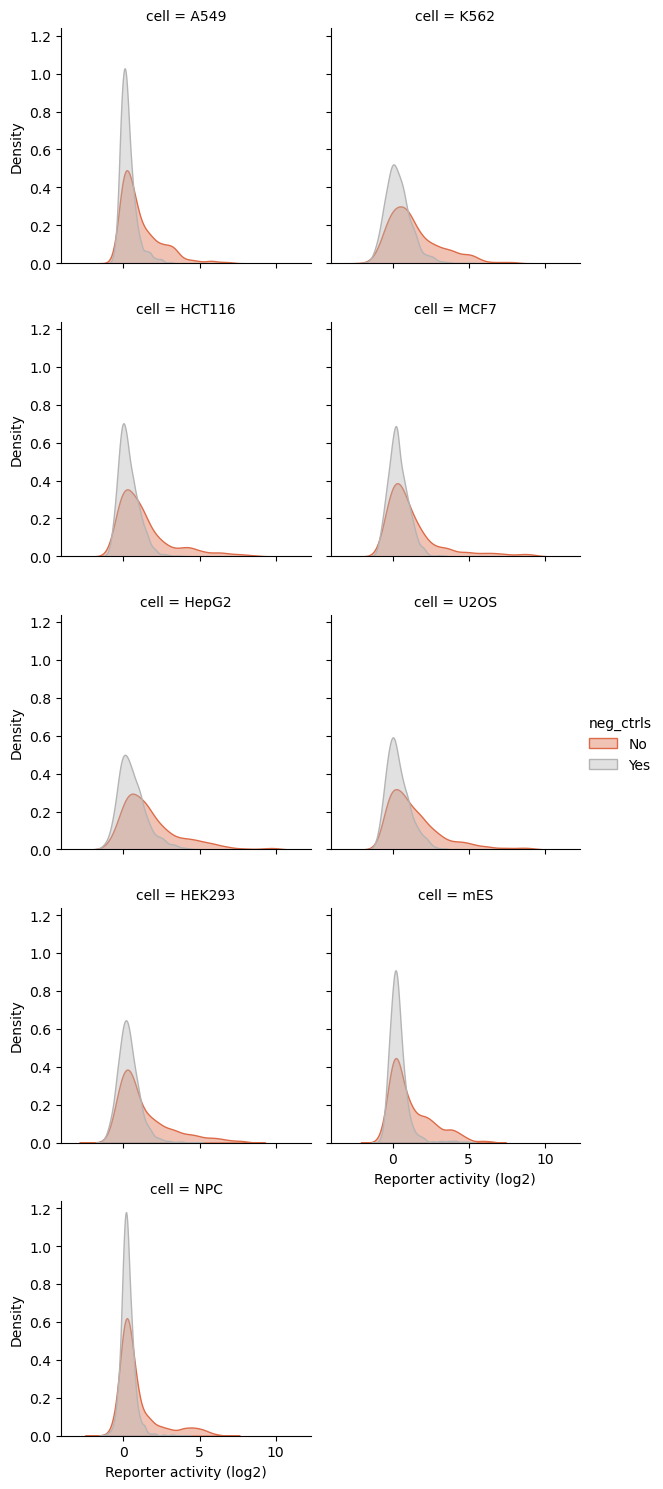

In [52]:
# Filter and transform cDNA_df
cDNA_df2 = cDNA_df.loc[
    (cDNA_df['stimulation'] == 'no') &
    (cDNA_df['commercial_reporter'] == 'No') &
    (cDNA_df['hPGK'] == 'No') &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == 'No')
]
cDNA_df2 = cDNA_df2[['tf', 'reporter_activity_minP', 'cell', 'reporter_id', 'neg_ctrls']].drop_duplicates()
cDNA_df2['reporter_activity_minP'] = cDNA_df2.groupby(['cell', 'reporter_id'])['reporter_activity_minP'].transform('mean')
cDNA_df2['reporter_activity_minP'] = np.log2(cDNA_df2['reporter_activity_minP'])
cDNA_df2 = cDNA_df2.drop_duplicates()

cell_order = ["A549", "K562", "HCT116", "MCF7", "HepG2", "U2OS", "HEK293", "mES", "NPC"]

# Create a FacetGrid
g = sns.FacetGrid(data=cDNA_df2, col='cell', col_wrap=2, col_order=cell_order, hue='neg_ctrls', palette=['#DD6B48', '#B4B4B4'])

# Map sns.kdeplot to the FacetGrid
g.map(sns.kdeplot, 'reporter_activity_minP', fill=True, alpha=0.4, common_norm=False)

# Add a legend
g.add_legend()

# Show the plot
## Add title and axis labels
g.set_axis_labels("Reporter activity (log2)", "Density")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/reporter_activity_density.pdf")
plt.show();

Conclusion: In all cell types: Reporters are more active with TFBS compared to mutated TFBS reporters.

---
### Plot native reporters vs. TF reporters

Aim: Compare activity levels of native sequences vs. synthetic TF reporters.

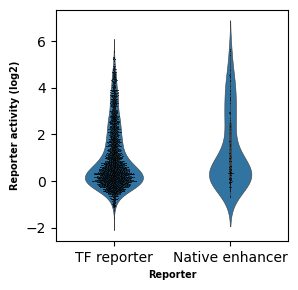

In [61]:
# Figure S1G: Compare TF reporters to native enhancer controls
native_activities = cDNA_df.loc[
    (cDNA_df['condition'] == 'mES_2i_LIF') &
    (cDNA_df['neg_ctrls'] == 'No')]
native_activities = native_activities[['reporter_id', 'tf', 'reporter_activity_minP', 'condition']].drop_duplicates()
native_activities['tf'] = native_activities['tf'].str.replace('_.*', '', regex=True)
native_activities['native_enhancer'] = np.where(native_activities['tf'].isin(['e97', 'e6', 'e19', 'e11', 'e93']), native_activities['tf'], 'tf_reporter')
native_activities['native_enhancer2'] = np.where(native_activities['native_enhancer'] == 'tf_reporter', native_activities['native_enhancer'], 'native_enhancer')

plt.figure(figsize=(3, 3))
# Beeswarm and violin plot using seaborn
sns.swarmplot(data=native_activities, x='native_enhancer2', y=np.log2(native_activities['reporter_activity_minP']), rasterized=True, color='black', size=0.5)
sns.violinplot(data=native_activities, x='native_enhancer2', y=np.log2(native_activities['reporter_activity_minP']), width=0.5, linewidth=0.4)
# Add labels
plt.ylabel("Reporter activity (log2)", weight = "bold")
plt.xlabel("Reporter", weight = "bold")
plt.xticks([0, 1], ["TF reporter", "Native enhancer"])
## Save plot to pdf
plt.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/native_enhancer_vs_tf_reporter.pdf")
plt.show();

Conclusion: TF reporters are on average less active, but can reach activities as high as native reporters.

---
### Plot median TF reporter activities per cell type

Aim: Show that there are differences in activities between cell types

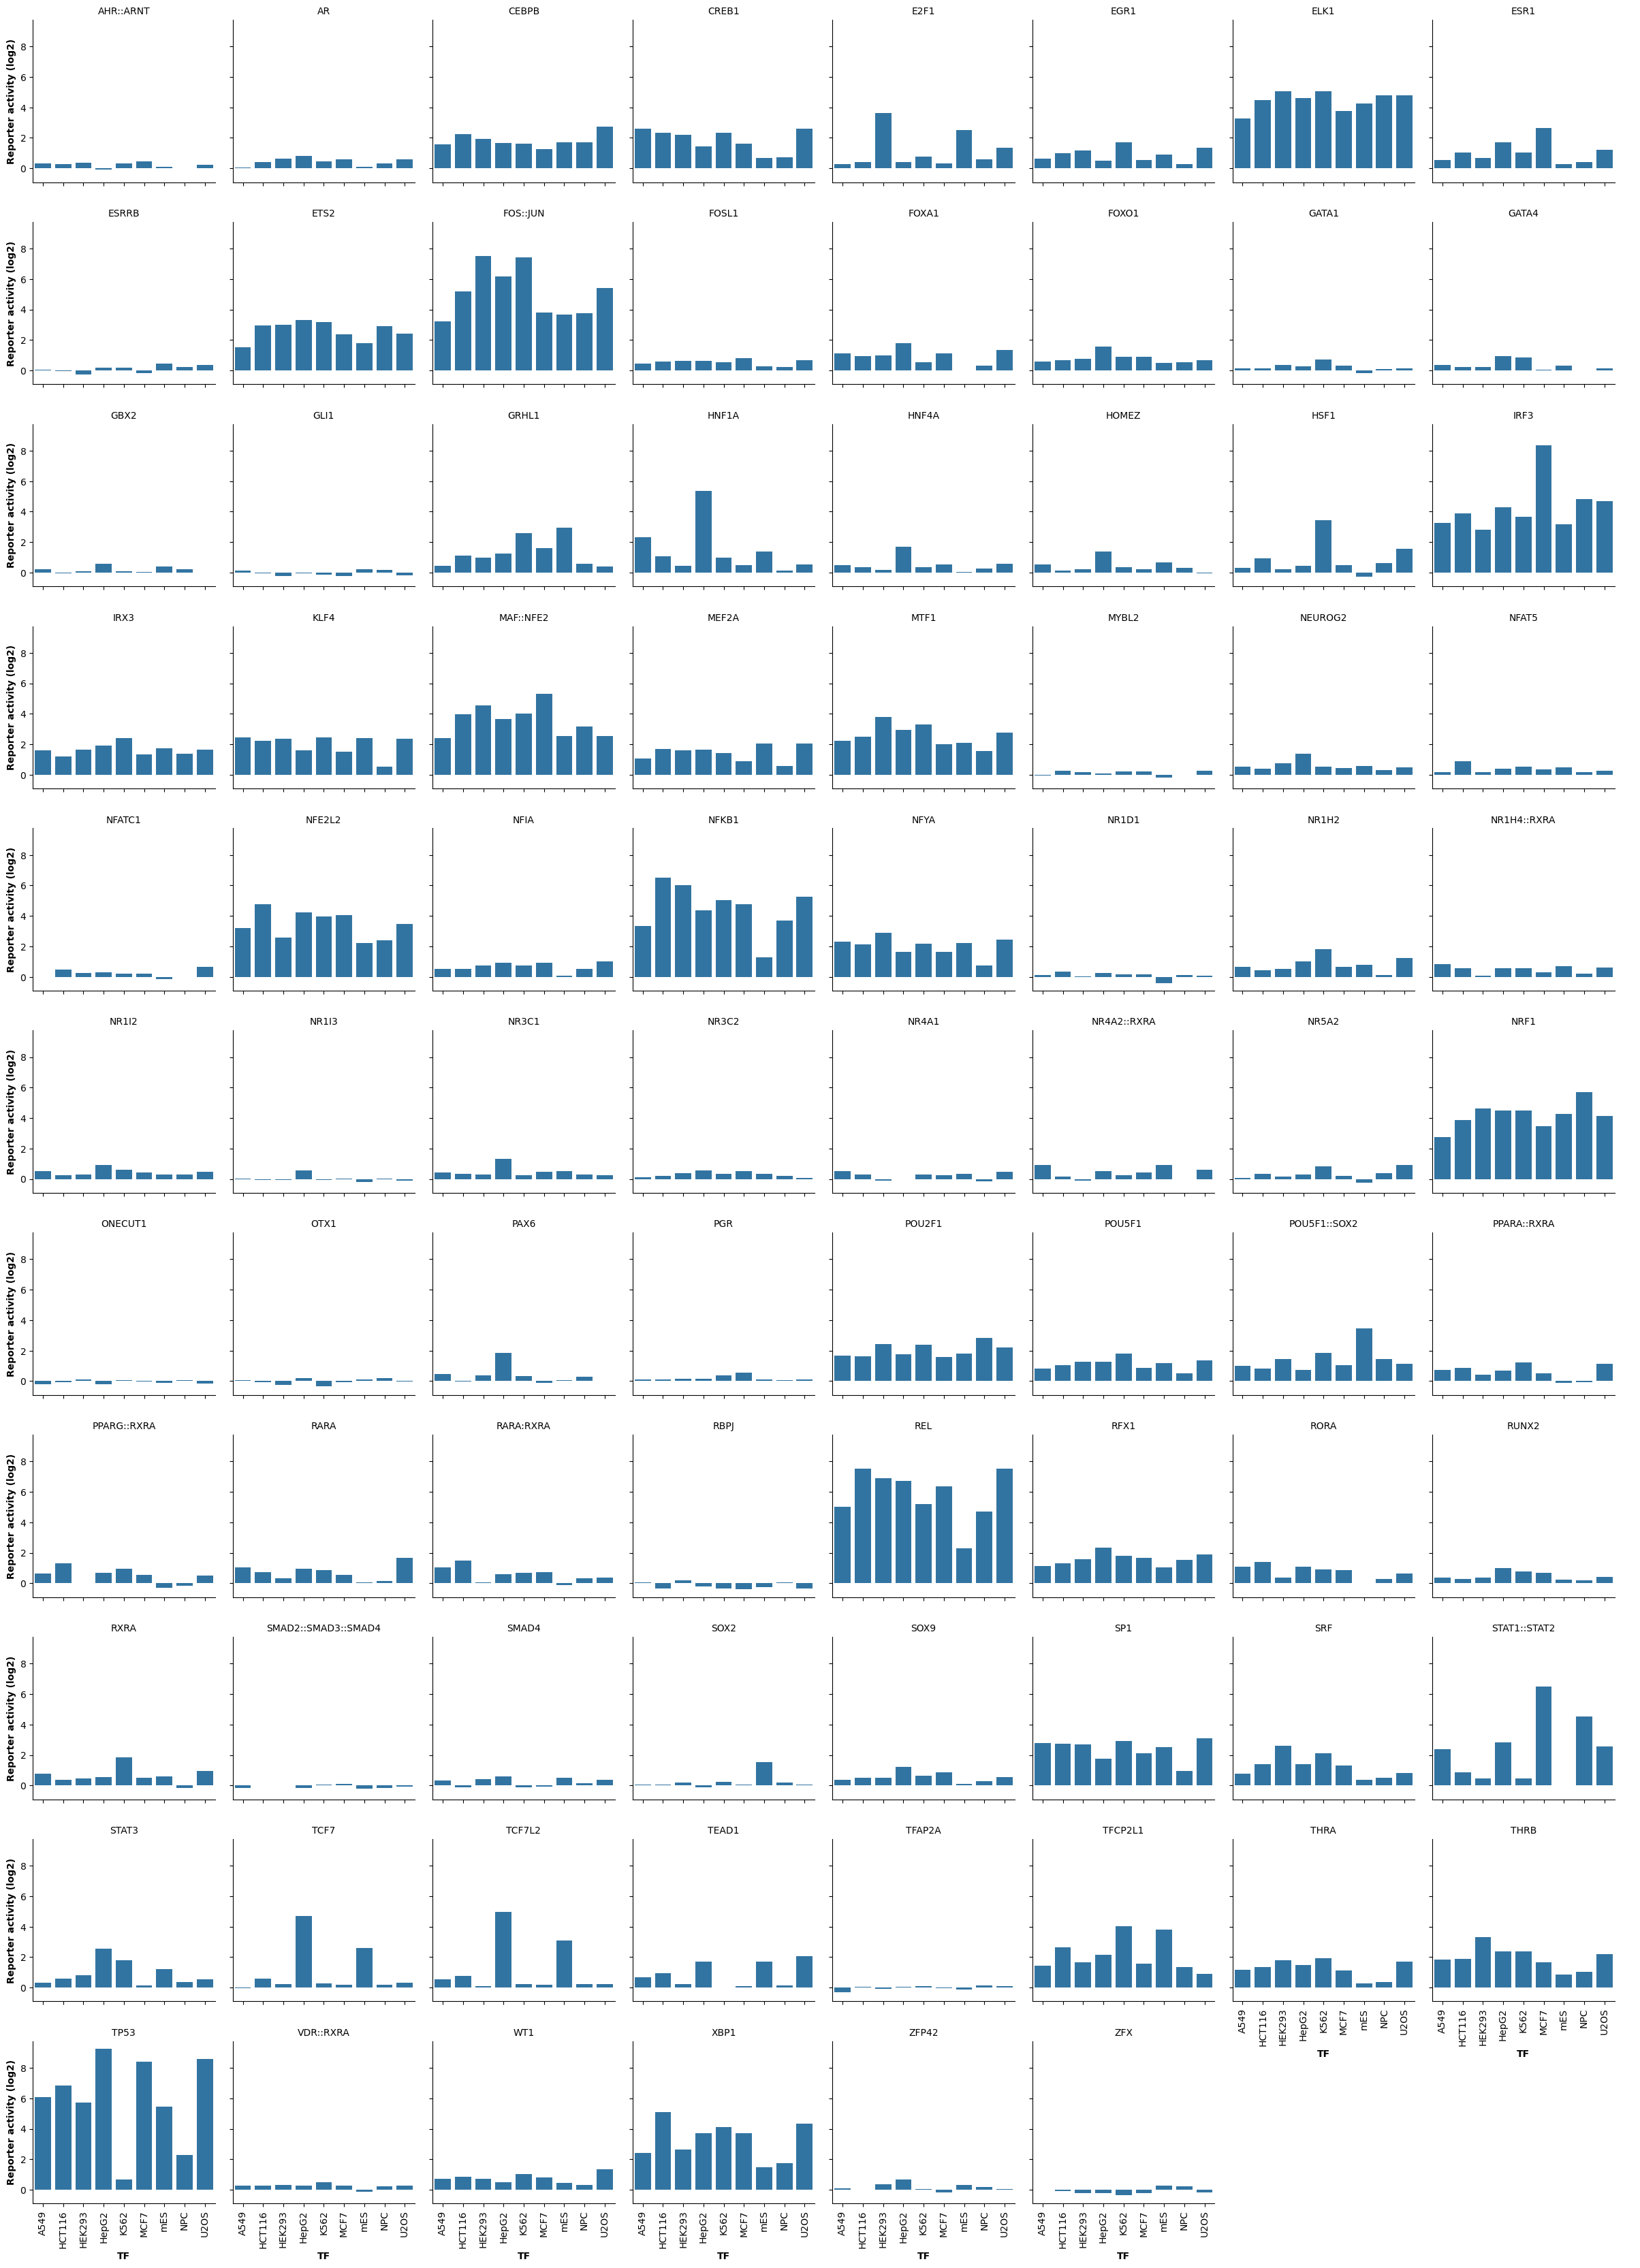

In [63]:
# Figure S2A: Median TF activities in all 9 cell types
tf_activities_median = cDNA_df.loc[
    (cDNA_df['stimulation'] == 'no') &
    (cDNA_df['neg_ctrls'] == 'No') &
    (cDNA_df['commercial_reporter'] == 'No') &
    (cDNA_df['hPGK'] == 'No') &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == 'No')]
tf_activities_median = tf_activities_median[['tf', 'reporter_activity_minP', 'cell', 'neg_ctrls']].drop_duplicates()
tf_activities_median['reporter_activity_minP'] = tf_activities_median.groupby(['cell', 'tf'])['reporter_activity_minP'].transform('median')
tf_activities_median['reporter_activity_minP'] = np.log2(tf_activities_median['reporter_activity_minP'])
tf_activities_median = tf_activities_median[['reporter_activity_minP', 'tf', 'cell']].drop_duplicates()

# Create a FacetGrid
g = sns.FacetGrid(data=tf_activities_median, col='tf', col_wrap=8)

# Map sns.barplot to the FacetGrid
g.map(sns.barplot, 'cell', 'reporter_activity_minP', dodge=False)

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add a legend
g.add_legend()

# Set the titles to only show the variable value
g.set_titles("{col_name}")

# Show the plot
## Add title and axis labels
g.set_axis_labels("TF", "Reporter activity (log2)", weight = "bold")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/tf_reporter_activity_median.pdf")
plt.show();

Conclusion: There are clear differences between cell types.

---
### Plot all individual TF reporter activities per cell type

Aim: Show that there are differences in activities between cell types + show that there is a spread between reporter variants of the same TF.

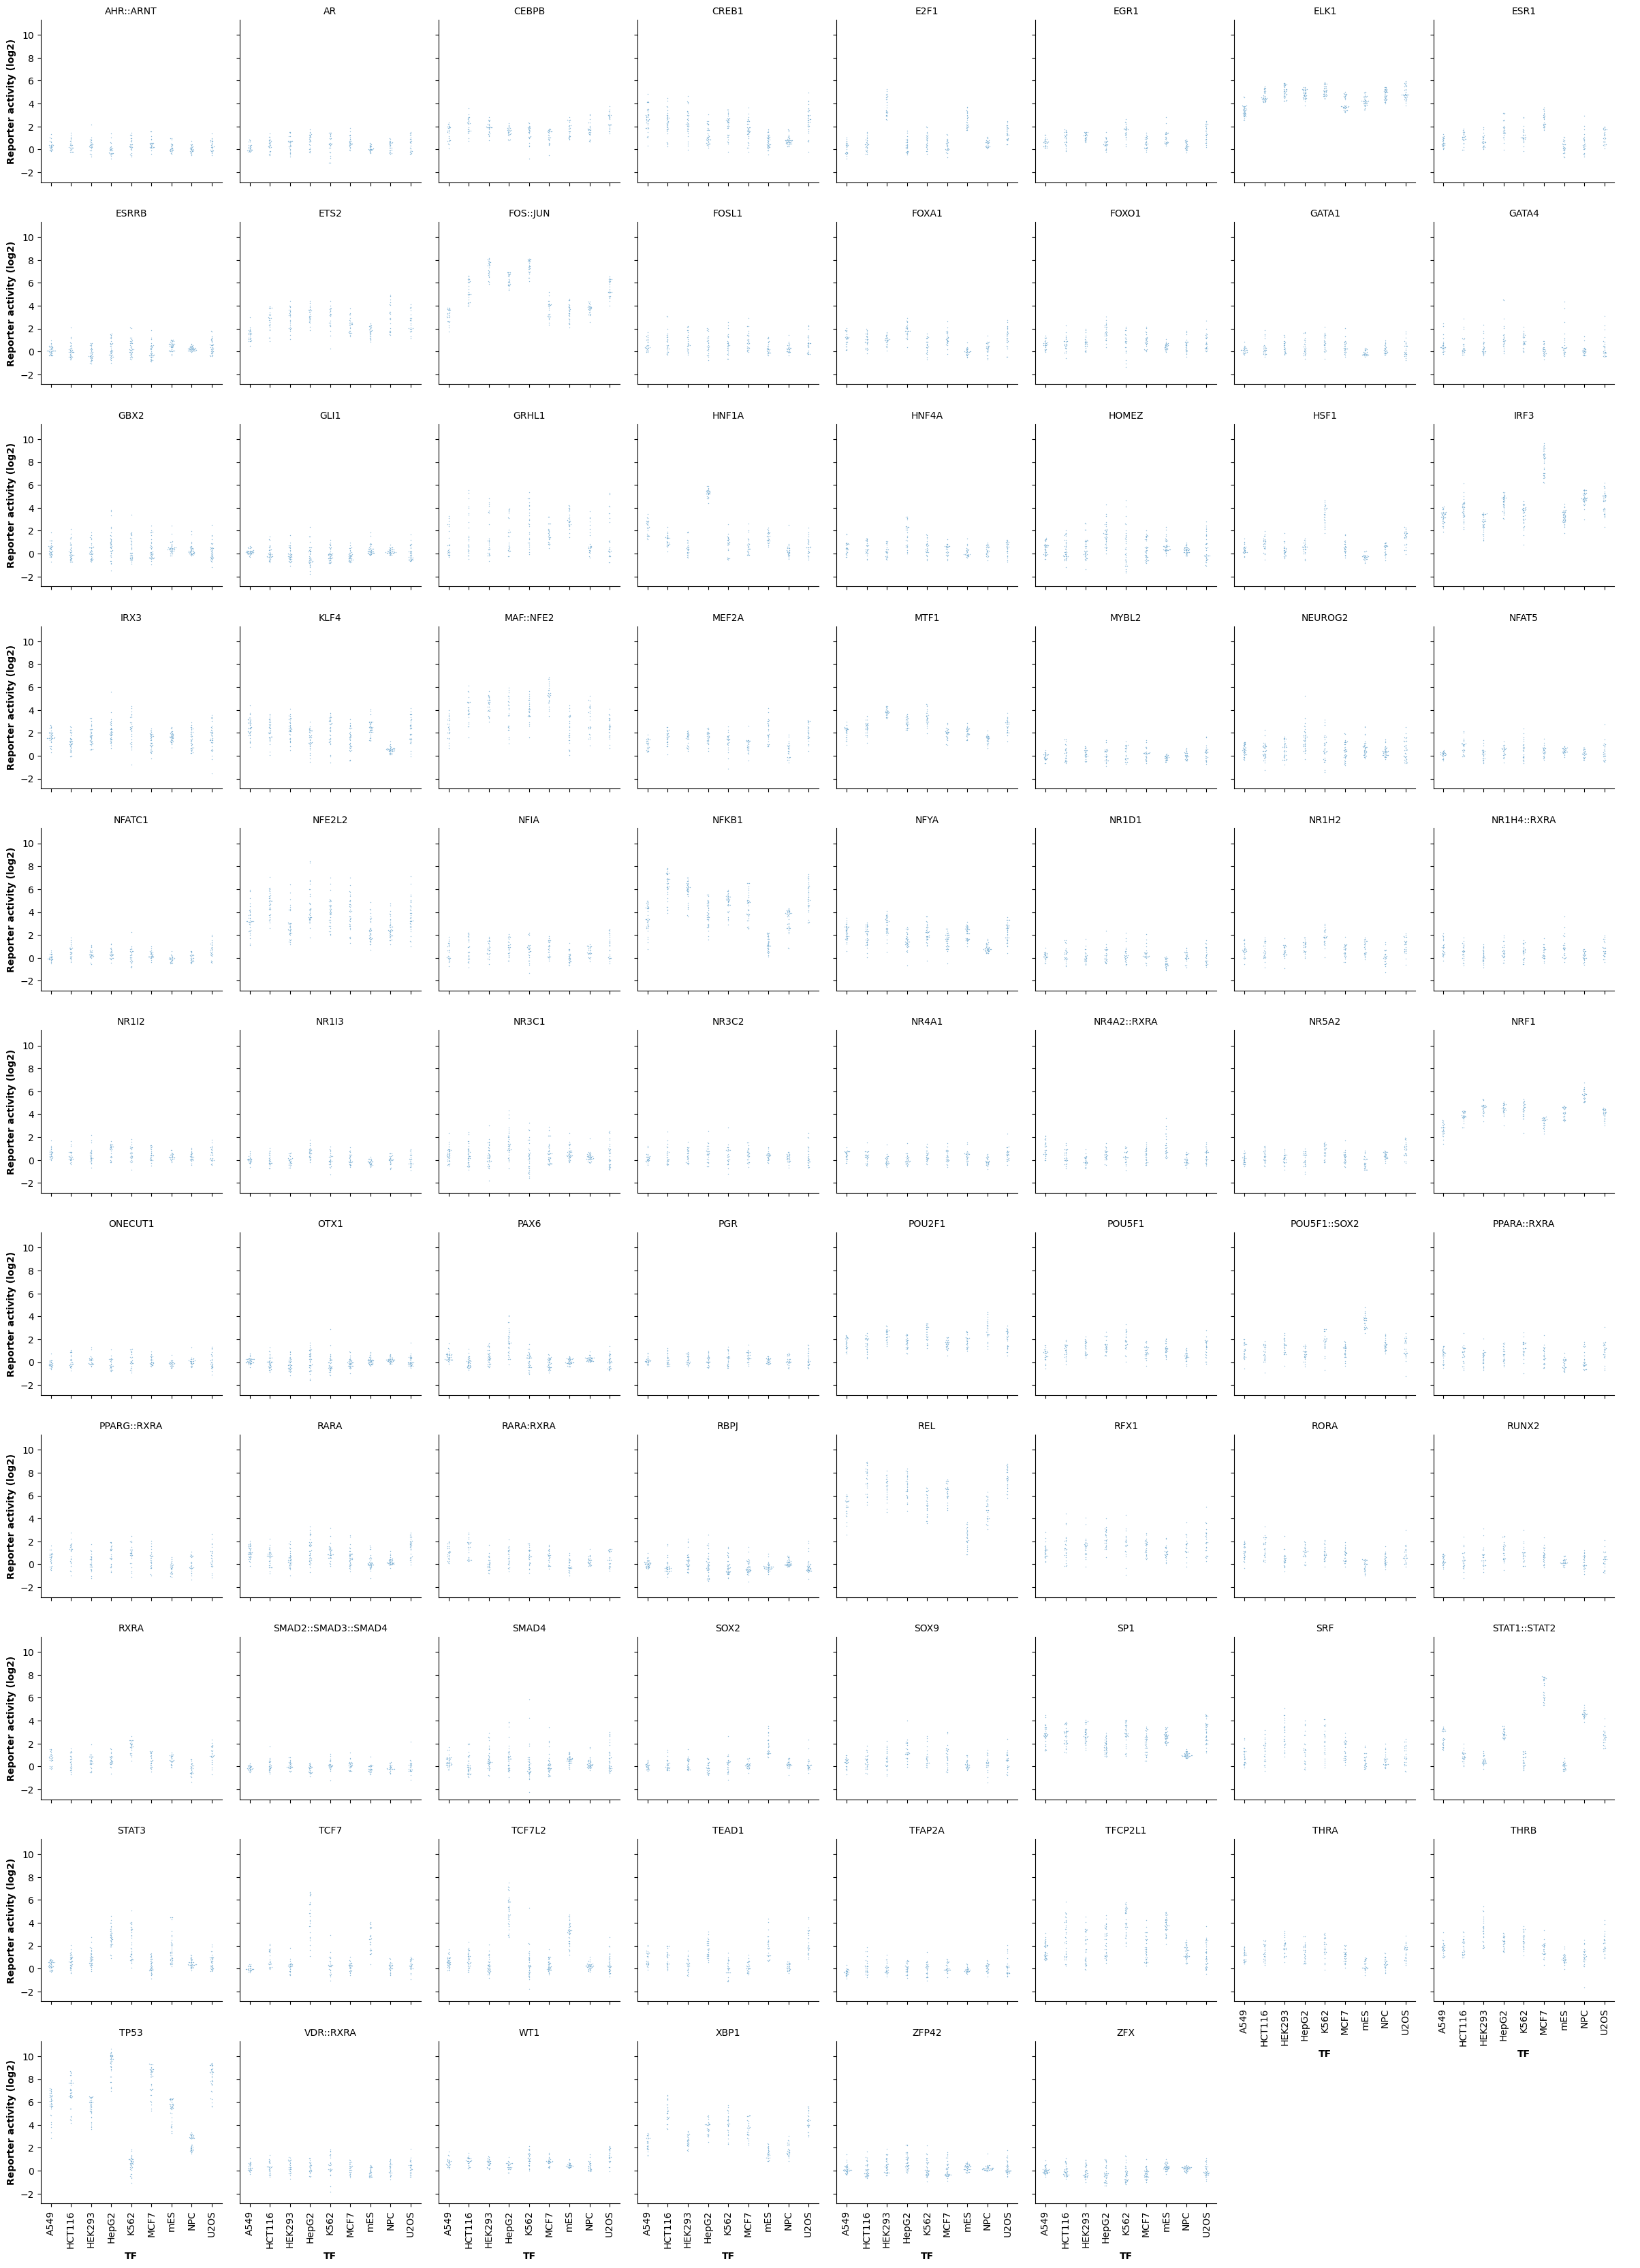

In [73]:
# Figure S2A: Median TF activities in all 9 cell types
tf_activities_median = cDNA_df.loc[
    (cDNA_df['stimulation'] == 'no') &
    (cDNA_df['neg_ctrls'] == 'No') &
    (cDNA_df['commercial_reporter'] == 'No') &
    (cDNA_df['hPGK'] == 'No') &
    (~cDNA_df['tf'].str.contains('RANDOM', case=False, na=False)) &
    (cDNA_df['native_enhancer'] == 'No')]
tf_activities_median = tf_activities_median[['tf', 'reporter_activity_minP', 'cell', 'reporter_id']].drop_duplicates()
tf_activities_median['reporter_activity_minP'] = tf_activities_median.groupby(['cell', 'tf', 'reporter_id'])['reporter_activity_minP'].transform('median')
tf_activities_median['reporter_activity_minP'] = np.log2(tf_activities_median['reporter_activity_minP'])
tf_activities_median = tf_activities_median[['reporter_activity_minP', 'tf', 'cell', 'reporter_id']].drop_duplicates()

# Create a FacetGrid
g = sns.FacetGrid(data=tf_activities_median, col='tf', col_wrap=8)

# Map sns.swarmplot to the FacetGrid
g.map(sns.swarmplot, 'cell', 'reporter_activity_minP', dodge=False, size=1, alpha=0.7)

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Add a legend
g.add_legend()

# Set the titles to only show the variable value
g.set_titles("{col_name}")

# Show the plot
## Add title and axis labels
g.set_axis_labels("TF", "Reporter activity (log2)", weight = "bold")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/tf_reporter_activity_median_swarm.pdf")
plt.show();